# Import libraries

In [2]:
from datetime import datetime, timedelta, timezone
import os
from typing import *
import random

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, log_loss, make_scorer, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split  

# Utils

In [3]:
def plot_feature_importance(importance, names, model_type, first_n=None):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names': feature_names,'feature_importance': feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
  if first_n is not None:
    fi_df = fi_df.iloc[:first_n, :]

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' feature importance')
  plt.xlabel('Feature importance')
  plt.ylabel('Feature names')
  plt.show()

In [4]:
def plot_confusion_matrix(test_y, predictions):
  labels = np.sort(np.array(test_y.unique(), dtype = 'str'))
  mat = confusion_matrix(test_y, predictions)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = labels, yticklabels = labels)
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.show()

In [5]:
def show_report(estimator, test_x, test_y, title, first_n=None):
  predictions = estimator.predict(test_x)
  print('Metrics values:')
  print('Test accuracy: %s' % round(accuracy_score(test_y, predictions), 4))
  print('Test balanced_accuracy', round(balanced_accuracy_score(test_y, predictions), 4))
  print('Test f1_score: %s' % round(f1_score(test_y, predictions, average='macro'), 4))
  print('Classification report')
  print(classification_report(test_y, predictions))
  print()
  
  plot_confusion_matrix(test_y, predictions)
  print()
  
  if type(estimator) == CalibratedClassifierCV:
      estimator = estimator.base_estimator
  importances = estimator.feature_importances_
  plot_feature_importance(importances, test_x.columns, title, first_n)

# Connect to Google Drive (if needed)

In [6]:
# Подключить к google colab содержимое вашего google диск
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


# Constants

In [7]:
SEED = 77

# Download data

> Data fetched from Dec2019_00004_20191206110000

> Contains 100k samples, 60k - normal case, 40k - attack case; features - bytes values (packet data cropped at first 625 bytes)

In [8]:
%%time
data = np.loadtxt('/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/not_aggregated/dataset_ep_bin_clf_experimental_first121b.csv', delimiter=',', dtype=np.float64)

CPU times: user 9.55 s, sys: 968 ms, total: 10.5 s
Wall time: 13.9 s


In [9]:
data.shape

(100000, 124)

In [10]:
data_df = pd.DataFrame(data)

data_df.rename({data_df.columns[-1]: 'label'}, axis=1, inplace=True)

data_df.columns = data_df.columns.astype(str)

# Split data to train/test

In [11]:
# train_x, test_x, train_y, test_y = train_test_split(data[:, :-3], data[:, -1], test_size=0.3, random_state=SEED)

In [12]:
train_data, test_data = train_test_split(data, stratify=data[:, -1], test_size=0.3, random_state=SEED)

In [13]:
train_data.shape, test_data.shape

((70000, 124), (30000, 124))

In [14]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_df.rename({train_df.columns[-1]: 'label'}, axis=1, inplace=True)
test_df.rename({test_df.columns[-1]: 'label'}, axis=1, inplace=True)

train_df.columns = train_df.columns.astype(str)
test_df.columns = test_df.columns.astype(str)

train_df.loc[:, 'label'] = train_df.loc[:, 'label'].astype(int)
test_df.loc[:, 'label'] = test_df.loc[:, 'label'].astype(int)

In [15]:
train_df.loc[:, 'label'].value_counts()

0    42000
1    28000
Name: label, dtype: int64

In [16]:
test_df.loc[:, 'label'].value_counts()

0    18000
1    12000
Name: label, dtype: int64

# Try to classify data

> Using classifier with dafault parameters

In [17]:
forest_clf = RandomForestClassifier(random_state=SEED)

In [18]:
%%time
forest_clf.fit(train_df.iloc[:, :-3], train_df.iloc[:, -1])

CPU times: user 22.5 s, sys: 59.3 ms, total: 22.6 s
Wall time: 22.6 s


RandomForestClassifier(random_state=77)

Metrics values:
Test accuracy: 0.9919
Test balanced_accuracy 0.9909
Test f1_score: 0.9916
Classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18000
           1       0.99      0.99      0.99     12000

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000




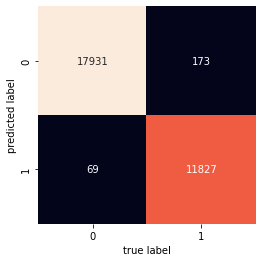

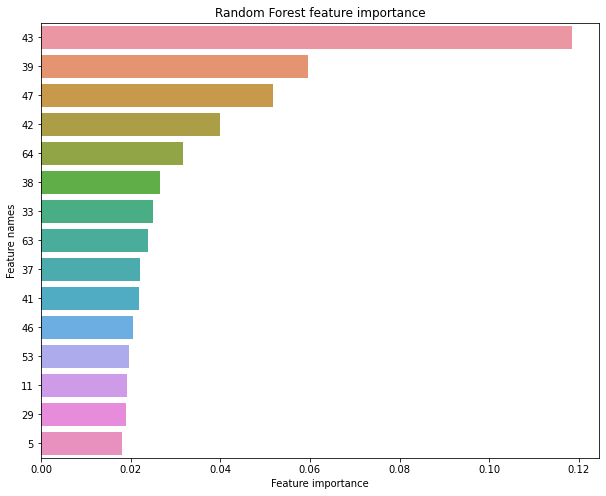

In [19]:
show_report(forest_clf, test_df.iloc[:, :-3], test_df.iloc[:, -1], title='Random Forest', first_n=15)

## Analyze

> Check difference between values of bytes in normal and attack case


Information about 43th byte

In [ ]:
data_df.loc[:, ['43', 'label']].groupby(by='label').describe()

43                                                       
         count        mean        std  min   25%    50%    75%    max
label                                                                
0.0    60000.0  114.152617  77.405492  0.0  51.0  106.0  189.0  255.0
1.0    40000.0  108.532100  78.319012  0.0  51.0  102.0  173.0  255.0

Information about 43th byte, not including values 0 and 255

In [ ]:
data_df.loc[~data_df.loc[:, '43'].isin([0, 255]), ['43', 'label']].groupby(by='label').describe()

43                                                       
         count        mean        std  min   25%    50%    75%    max
label                                                                
0.0    54254.0  125.701921  71.402108  1.0  53.0  130.0  193.0  254.0
1.0    36278.0  119.322702  73.655626  1.0  54.0  117.0  179.0  254.0

Information about 43th byte, about values 0 and 255

In [ ]:
print('Fraction of 0 in normal samples = %s%%' % round(sum(data_df.loc[:, '43'] == 0) / sum(data_df.loc[:, 'label'] == 0) * 100, 1))
print('Fraction of 0 in attack samples = %s%%' % round(sum(data_df.loc[:, '43'] == 0) / sum(data_df.loc[:, 'label'] == 1) * 100, 1))

Fraction of 0 in normal samples = 15.5%
Fraction of 0 in attack samples = 23.3%


In [ ]:
print('Fraction of 255 in normal samples = %s%%' % round(sum(data_df.loc[:, '43'] == 255) / sum(data_df.loc[:, 'label'] == 0) * 100, 1))
print('Fraction of 255 in attack samples = %s%%' % round(sum(data_df.loc[:, '43'] == 255) / sum(data_df.loc[:, 'label'] == 1) * 100, 1))

Fraction of 255 in normal samples = 0.3%
Fraction of 255 in attack samples = 0.4%


39th byte

In [ ]:
data_df.loc[:, ['39', 'label']].groupby(by='label').describe()

39                                                      
         count        mean        std  min   25%   50%    75%    max
label                                                               
0.0    60000.0  108.153817  76.723564  0.0  36.0  90.0  174.0  255.0
1.0    40000.0  106.044175  77.087214  0.0  26.0  93.0  174.0  255.0

47th byte

In [ ]:
data_df.loc[:, ['47', 'label']].groupby(by='label').describe()

47                                                     
         count       mean        std  min   25%   50%    75%    max
label                                                              
0.0    60000.0  62.366717  74.639721  0.0  16.0  24.0  102.0  255.0
1.0    40000.0  59.494550  73.038608  0.0  16.0  24.0  101.0  255.0

## Predict another attack type

In [ ]:
%%time
DSA_data = np.loadtxt('/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/not_aggregated/dataset_ep_bin_clf_experimental_first121b_small_DSA.csv', delimiter=',', dtype=np.float64)

CPU times: user 2.92 s, sys: 195 ms, total: 3.11 s
Wall time: 4.61 s


In [ ]:
DSA_data.shape

(20000, 124)

In [ ]:
DSA_data_df = pd.DataFrame(DSA_data)

DSA_data_df.rename({DSA_data_df.columns[-1]: 'label'}, axis=1, inplace=True)

DSA_data_df.columns = DSA_data_df.columns.astype(str)

Metrics values:
Test accuracy: 0.5454
Test balanced_accuracy 0.5102
Test f1_score: 0.5073
Classification report
              precision    recall  f1-score   support

         0.0       0.61      0.69      0.64     12000
         1.0       0.42      0.33      0.37      8000

    accuracy                           0.55     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.53      0.55      0.53     20000




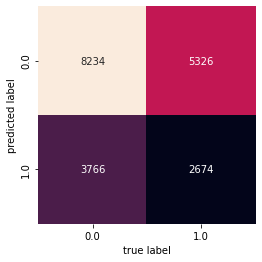

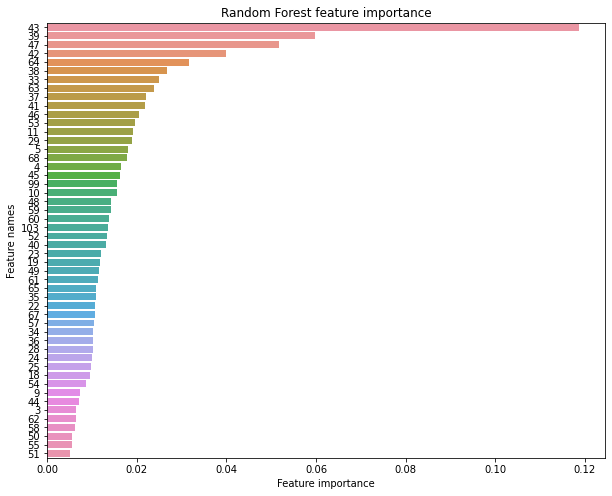

In [ ]:
show_report(forest_clf, DSA_data_df.iloc[:, :-3], DSA_data_df.iloc[:, -1], title='Random Forest', first_n=50)

## Try to fit on DSA attack

### Download data

In [ ]:
%%time
DSA_data = np.loadtxt('/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/not_aggregated/dataset_ep_bin_clf_experimental_first121b_DSA.csv', delimiter=',', dtype=np.float64)

CPU times: user 9.58 s, sys: 1.01 s, total: 10.6 s
Wall time: 11.7 s


In [ ]:
DSA_data.shape

(100000, 124)

In [ ]:
DSA_data_df = pd.DataFrame(DSA_data)

DSA_data_df.rename({DSA_data_df.columns[-1]: 'label'}, axis=1, inplace=True)

DSA_data_df.columns = DSA_data_df.columns.astype(str)

### Split data to train/test

In [ ]:
# train_x, test_x, train_y, test_y = train_test_split(data[:, :-3], data[:, -1], test_size=0.3, random_state=SEED)

In [ ]:
DSA_train_df, DSA_test_df = train_test_split(DSA_data_df, stratify=DSA_data_df.iloc[:, -1], test_size=0.3, random_state=SEED)

In [ ]:
DSA_train_df.shape, DSA_test_df.shape

((70000, 124), (30000, 124))

In [ ]:
DSA_train_df.loc[:, 'label'].value_counts()

0.0    42000
1.0    28000
Name: label, dtype: int64

In [ ]:
DSA_test_df.loc[:, 'label'].value_counts()

0.0    18000
1.0    12000
Name: label, dtype: int64

### Try to classify

In [ ]:
forest_clf_DSA = RandomForestClassifier(random_state=SEED)

In [ ]:
%%time
forest_clf_DSA.fit(DSA_train_df.iloc[:, :-3], DSA_train_df.iloc[:, -1])

CPU times: user 26.5 s, sys: 110 ms, total: 26.6 s
Wall time: 26.9 s


RandomForestClassifier(random_state=77)

Metrics values:
Test accuracy: 0.9911
Test balanced_accuracy 0.9897
Test f1_score: 0.9907
Classification report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     18000
         1.0       1.00      0.98      0.99     12000

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000




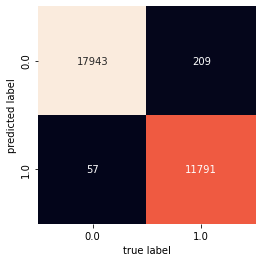

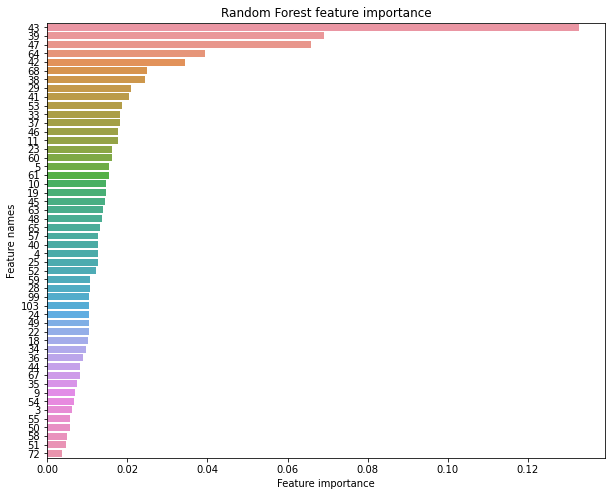

In [ ]:
show_report(forest_clf_DSA, DSA_test_df.iloc[:, :-3], DSA_test_df.iloc[:, -1], title='Random Forest', first_n=50)

### Analyze

> Check difference between values of bytes in normal and attack case


Information about 43th byte

In [ ]:
DSA_data_df.loc[:, ['43', 'label']].groupby(by='label').describe()

43                                                       
         count        mean        std  min   25%    50%    75%    max
label                                                                
0.0    60000.0  118.990983  78.971064  0.0  52.0  129.0  182.0  255.0
1.0    40000.0  120.737150  75.755742  0.0  60.0  119.0  186.0  255.0

In [ ]:
data_df.loc[:, ['43', 'label']].groupby(by='label').describe()

43                                                       
         count        mean        std  min   25%    50%    75%    max
label                                                                
0.0    60000.0  114.152617  77.405492  0.0  51.0  106.0  189.0  255.0
1.0    40000.0  108.532100  78.319012  0.0  51.0  102.0  173.0  255.0

Information about 43th byte, not including values 0 and 255

In [ ]:
DSA_data_df.loc[~DSA_data_df.loc[:, '43'].isin([0, 255]), ['43', 'label']].groupby(by='label').describe()

43                                                       
         count        mean        std  min   25%    50%    75%    max
label                                                                
0.0    54131.0  130.888844  72.241323  1.0  64.0  139.0  185.0  254.0
1.0    36238.0  132.919477  68.324044  1.0  76.0  128.0  189.0  254.0

In [ ]:
data_df.loc[~data_df.loc[:, '43'].isin([0, 255]), ['43', 'label']].groupby(by='label').describe()

43                                                       
         count        mean        std  min   25%    50%    75%    max
label                                                                
0.0    54254.0  125.701921  71.402108  1.0  53.0  130.0  193.0  254.0
1.0    36278.0  119.322702  73.655626  1.0  54.0  117.0  179.0  254.0

Information about 43th byte, about values 0 and 255

In [ ]:
print('Fraction of 0 in normal samples = %s%%' % round(sum(DSA_data_df.loc[:, '43'] == 0) / sum(DSA_data_df.loc[:, 'label'] == 0) * 100, 1))
print('Fraction of 0 in attack samples = %s%%' % round(sum(DSA_data_df.loc[:, '43'] == 0) / sum(DSA_data_df.loc[:, 'label'] == 1) * 100, 1))

Fraction of 0 in normal samples = 15.6%
Fraction of 0 in attack samples = 23.4%


In [ ]:
print('Fraction of 255 in normal samples = %s%%' % round(sum(DSA_data_df.loc[:, '43'] == 255) / sum(DSA_data_df.loc[:, 'label'] == 0) * 100, 1))
print('Fraction of 255 in attack samples = %s%%' % round(sum(DSA_data_df.loc[:, '43'] == 255) / sum(DSA_data_df.loc[:, 'label'] == 1) * 100, 1))

Fraction of 255 in normal samples = 0.4%
Fraction of 255 in attack samples = 0.7%


In [ ]:
print('Fraction of 0 in normal samples = %s%%' % round(sum(data_df.loc[:, '43'] == 0) / sum(data_df.loc[:, 'label'] == 0) * 100, 1))
print('Fraction of 0 in attack samples = %s%%' % round(sum(data_df.loc[:, '43'] == 0) / sum(data_df.loc[:, 'label'] == 1) * 100, 1))

Fraction of 0 in normal samples = 15.5%
Fraction of 0 in attack samples = 23.3%


In [ ]:
print('Fraction of 255 in normal samples = %s%%' % round(sum(data_df.loc[:, '43'] == 255) / sum(data_df.loc[:, 'label'] == 0) * 100, 1))
print('Fraction of 255 in attack samples = %s%%' % round(sum(data_df.loc[:, '43'] == 255) / sum(data_df.loc[:, 'label'] == 1) * 100, 1))

Fraction of 255 in normal samples = 0.3%
Fraction of 255 in attack samples = 0.4%


In [ ]:
df_for_plot = pd.concat([pd.concat([data_df.loc[:, '43'].rename('43th_byte_value'), pd.Series(['EHD']*data_df.shape[0], name='attack_type')], axis=1), 
                         pd.concat([DSA_data_df.loc[:, '43'].rename('43th_byte_value'), pd.Series(['DSA']*DSA_data_df.shape[0], name='attack_type')], axis=1)]).reset_index(drop=True)
df_for_plot

,43th_byte_value,attack_type
0,0.0,EHD
1,209.0,EHD
2,231.0,EHD
3,220.0,EHD
4,44.0,EHD
...,...,...
199995,64.0,DSA
199996,118.0,DSA
199997,161.0,DSA
199998,210.0,DSA


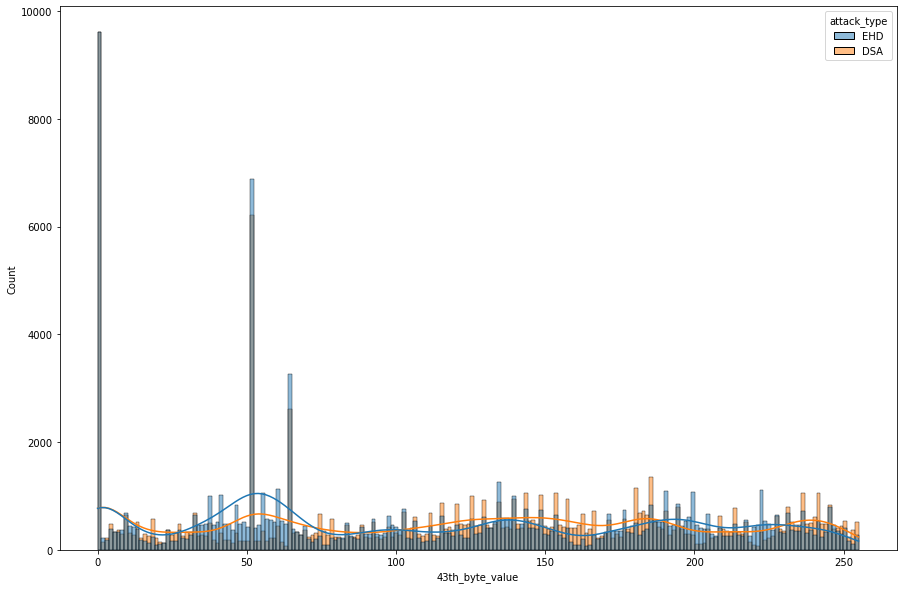

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df_for_plot, x='43th_byte_value', hue='attack_type', kde=True, bins=200)

In [ ]:
pd.concat([data_df.loc[:, '43'].rename('EHD_43th_byte'), pd.Series(['EHD_43th_byte']*data_df.shape[0], name='attack_type')], axis=1)

,EHD_43th_byte,attack_type
0,0.0,EHD_43th_byte
1,209.0,EHD_43th_byte
2,231.0,EHD_43th_byte
3,220.0,EHD_43th_byte
4,44.0,EHD_43th_byte
...,...,...
99995,150.0,EHD_43th_byte
99996,124.0,EHD_43th_byte
99997,80.0,EHD_43th_byte
99998,75.0,EHD_43th_byte


# Try to classify aggregated data

> Using classifier with dafault parameters

In [ ]:
forest_clf_ds = RandomForestClassifier(random_state=SEED)

In [ ]:
%%time
forest_clf_ds.fit(train_df.iloc[:, :100], train_df.iloc[:, -1])

CPU times: user 21.4 s, sys: 56.9 ms, total: 21.5 s
Wall time: 21.7 s


RandomForestClassifier(random_state=77)

Metrics values:
Test accuracy: 0.9918
Test balanced_accuracy 0.9906
Test f1_score: 0.9915
Classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18000
           1       0.99      0.98      0.99     12000

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000




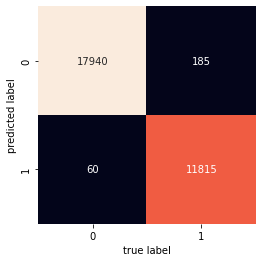

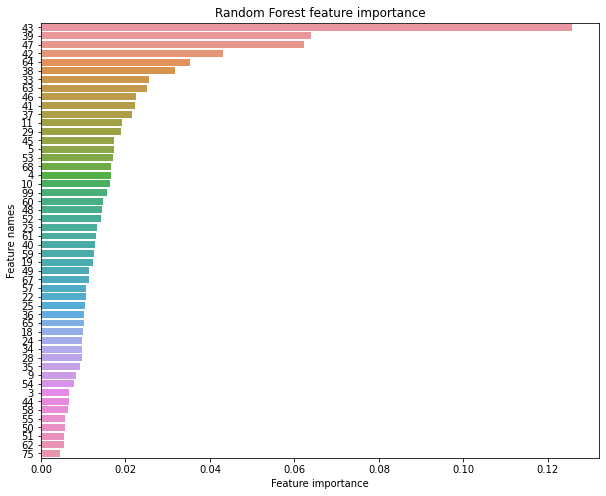

In [ ]:
show_report(forest_clf_ds, test_df.iloc[:, :100], test_df.iloc[:, -1], title='Random Forest', first_n=50)

## Download data

> Data fetched from Dec2019_00004_20191206110000

> Contains 100k samples, 60k - normal case, 40k - attack case; features - bytes values (packet data cropped at first 625 bytes)

In [ ]:
%%time
data = np.loadtxt('/content/drive/MyDrive/Master/MW_Semenov_6381/datasets/SWaT/SWaT_2019/aggregated/dataset_pp_ts.csv', delimiter=',', dtype=np.float64)
data.shape

CPU times: user 19.9 s, sys: 2.29 s, total: 22.2 s
Wall time: 25.7 s


In [ ]:
data_df = pd.DataFrame(data)

data_df.rename({data_df.columns[-1]: 'label'}, axis=1, inplace=True)

data_df.columns = data_df.columns.astype(str)

## Split data to train/test

In [ ]:
# train_x, test_x, train_y, test_y = train_test_split(data[:, :-3], data[:, -1], test_size=0.3, random_state=SEED)

In [ ]:
train_data, test_data = train_test_split(data, stratify=data[:, -1], test_size=0.3, random_state=SEED)

In [ ]:
train_data.shape, test_data.shape

((12560, 1229), (5383, 1229))

In [ ]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_df.rename({train_df.columns[-1]: 'label'}, axis=1, inplace=True)
test_df.rename({test_df.columns[-1]: 'label'}, axis=1, inplace=True)

train_df.columns = train_df.columns.astype(str)
test_df.columns = test_df.columns.astype(str)

train_df.loc[:, 'label'] = train_df.loc[:, 'label'].astype(int)
test_df.loc[:, 'label'] = test_df.loc[:, 'label'].astype(int)

In [ ]:
train_df.loc[:, 'label'].value_counts()

0    8370
1    4190
Name: label, dtype: int64

In [ ]:
test_df.loc[:, 'label'].value_counts()

0    3587
1    1796
Name: label, dtype: int64

## Try to classify data

> Using classifier with dafault parameters

In [ ]:
forest_clf = RandomForestClassifier(random_state=SEED)

In [ ]:
%%time
forest_clf.fit(train_df.iloc[:, :-4], train_df.iloc[:, -1])

CPU times: user 56.4 s, sys: 131 ms, total: 56.5 s
Wall time: 57.2 s


RandomForestClassifier(random_state=77)

Metrics values:
Test accuracy: 0.6723
Test balanced_accuracy 0.5195
Test f1_score: 0.4542
Classification report
              precision    recall  f1-score   support

           0       0.68      0.98      0.80      3587
           1       0.59      0.06      0.11      1796

    accuracy                           0.67      5383
   macro avg       0.63      0.52      0.45      5383
weighted avg       0.65      0.67      0.57      5383




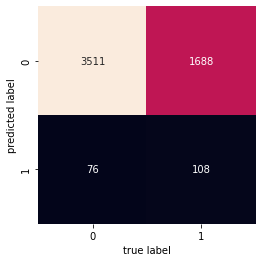

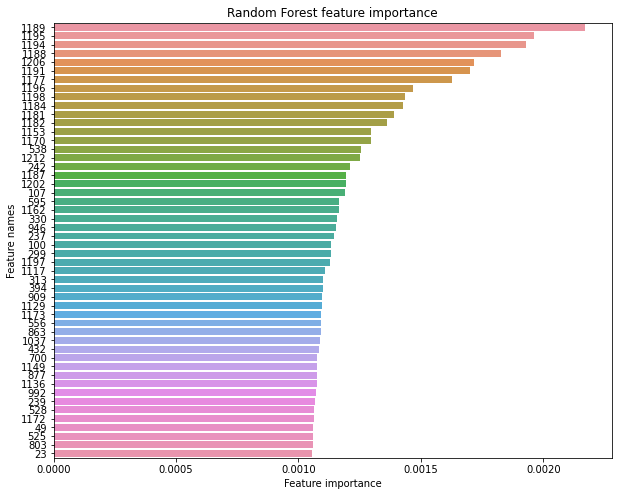

In [ ]:
show_report(forest_clf, test_df.iloc[:, :-4], test_df.iloc[:, -1], title='Random Forest', first_n=50)